## Isomer Design dataset HDBScan clustering model with Chem-MRL model example

In [1]:
import gc

import joblib
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from cuml.cluster.hdbscan import (
    HDBSCAN,
    approximate_predict,
)

# use rdkit to visual smiles
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
train_ds_file = "data/chem/isomer_design_test.parquet"
val_ds_file = "data/chem/isomer_design_val.parquet"
model_name = "output/ChemBERTa-zinc-base--classification-model-epochs_3-mrl_dim_768-lr_3.4038386108141304e-06-batch_size_160-warmup_steps_percent_2-scheduler_warmupcosine-dropout_p_0.15-loss_SoftMax"
# model_name = "output/ChemBERTa-zinc-base-v1-2d-matryoshka-embeddings-n_layers_per_step_2-TaniLoss-lr_1.1190785944700813e-05-batch_size_8-num_epochs_2-epoch_2-best-model-1900000_steps"
# model_name = "output/ChemBERTa-zinc-base-v1-QED_functional_morgan_fingerprint-2d-matryoshka-embeddings-num_epochs_2-epoch_2-best-model-1900000_steps"
# model_name = "output/ChemBERTa-zinc-base-v1-QED_morgan_fingerprint-2d-matryoshka-embeddings-num_epochs_2-epoch_4-best-model-1900000_steps"
model_name_abbv = model_name[30:]

In [ ]:
import pandas as pd
import cv2
import base64
import numpy as np


def update_width_and_height_to_isomer_design_df(ds_file):

    df = pd.read_parquet(ds_file)
    df["png_base64"] = df["png_2D"].str.strip("data:image/img;base64,")
    del df["png_base64"]
    # ex: 'data:image/png;base64,...=='

    def readb64(uri):
        uri = uri.split(",")[1] # equiv. to .strip() above
        nparr = np.frombuffer(base64.b64decode(uri), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

    df["width"] = 0
    df["height"] = 0
    for i, row in df.iterrows():
        img = readb64(row["png_2D"])
        df.at[i, "width"] = img.shape[1]
        df.at[i, "height"] = img.shape[0]

    print(df["width"].head(3))
    df.to_parquet(train_ds_file, engine="fastparquet", compression="zstd", index=False)


update_width_and_height_to_isomer_design_df(train_ds_file)

In [ ]:
df = pd.read_parquet(train_ds_file)
val_df = pd.read_parquet(val_ds_file)

enable_truncate_dim = True
truncate_dim = 16
use_half_precision = False
precision = "float16" if use_half_precision else "float32"

model = SentenceTransformer(
    model_name,
    device="cuda",
    truncate_dim=truncate_dim if enable_truncate_dim else None,
)

if use_half_precision:
    model = model.half()


# Compute the SMILES embeddings
smiles_embeddings: np.ndarray = model.encode(  # type: ignore
    df["smiles"],
    batch_size=1024,
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda",
    normalize_embeddings=enable_truncate_dim,
)

val_smiles_embeddings: np.ndarray = model.encode(  # type: ignore
    val_df["smiles"],
    batch_size=1024,
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda",
    normalize_embeddings=enable_truncate_dim,
)

del model
torch.cuda.empty_cache()
gc.collect()

### Train Isomer Design HDBScan clustering model with various minimum cluster sizes.

In [8]:
min_cluster_sizes = [5, 10, 15, 25]
for min_cluster_size in min_cluster_sizes:
    cluster_model_path = f"output/clusters/{model_name_abbv}-min_cluster_size_{min_cluster_size}-{precision}.bz2"
    gc.collect()
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="l2",
        cluster_selection_method="eom",
        prediction_data=True,
    )
    clusterer.fit(smiles_embeddings)
    filename = cluster_model_path
    joblib.dump(clusterer, filename, compress=("bz2", 3))
    del clusterer
    gc.collect()

### Evaluate Isomer Design HDBScan clustering model

In [10]:
clusterer = joblib.load(cluster_model_path)
prediction = approximate_predict(clusterer, val_smiles_embeddings)
pd.Series(clusterer.labels_).value_counts()

-1    1303
 2      93
 1      65
 0      25
Name: count, dtype: int64

#### Cluster group `0` contains several known fentanyl analogs featuring the fentanyl pharmacophore. However, the predictions are not perfect, as some unknown samples do not include the fentanyl pharmacophore.

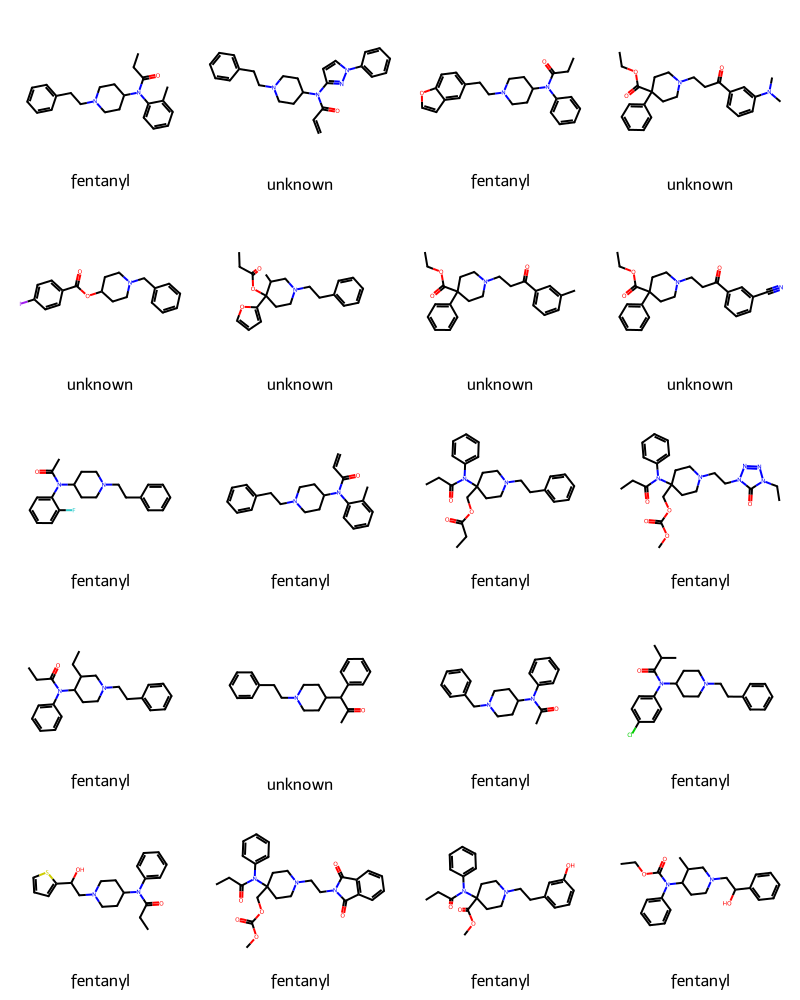

In [18]:
def mols_grid(df: pd.DataFrame, label: int, num_mols=20, use_prediction=False):
    if not use_prediction:
        smiles = df.loc[clusterer.labels_ == label].smiles.head(num_mols)
        labels = df.loc[clusterer.labels_ == label].category.head(num_mols)
        legends = labels
    else:
        predicted_label, _ = prediction
        labels = df.loc[predicted_label == label].category.head(num_mols)
        smiles = df.loc[predicted_label == label].smiles.head(num_mols)
        legends = labels

    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles]

    return Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, legends=legends.to_list())

mols_grid(df, 0, use_prediction=True)